# BİYOMEDİKAL GÖRÜNTÜ SEGMENTASYONU VE TANIMA 
Hazırlayan: Erkin SARIGİL

In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from os.path import isfile, join
import random

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras import metrics

In [2]:
DIR = "C:\\Users\\90505\\lgg-mri-segmentation\\kaggle_3m"
INPUT_CHANNELS = 3
TARGET_CHANNELS = 1
SIZE = 256
BATCH_SIZE = 32

# Data Preperation

In [3]:
mri_images_with_tumer = []
mri_images_without_tumer = []
mask_images_with_tumer = []
mask_images_without_tumer = []

patients = os.listdir(DIR)
for patient in tqdm(patients):
    if isfile(join(DIR, patient)) == False:
        images = os.listdir(join(DIR, patient))
        mask_images = list(filter(lambda x: x.find('mask') != -1, images))
        mri_images = list(filter(lambda x: x.find('mask') == -1, images))
        
        for mask_image in mask_images:
            mask = np.asarray(load_img(
                join(DIR, patient, mask_image), 
                target_size=(SIZE, SIZE), 
                color_mode="grayscale"))
            if np.amax(mask) != 0:
                mri_images_with_tumer.append(join(patient, mask_image.replace('_mask', '')))
                mask_images_with_tumer.append(join(patient, mask_image))
            else:
                mri_images_without_tumer.append(join(patient, mask_image.replace('_mask', '')))
                mask_images_without_tumer.append(join(patient, mask_image))

100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:06<00:00, 16.96it/s]


Total MRI images:  3929
Total mask images:  3929
Total images with tumer:  1373
Total images without tumer:  2556


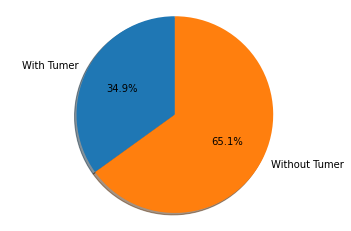

In [4]:
random.Random(1337).shuffle(mri_images_with_tumer)
random.Random(1337).shuffle(mask_images_with_tumer)
random.Random(1337).shuffle(mri_images_without_tumer)
random.Random(1337).shuffle(mask_images_without_tumer)


print("Total MRI images: ", len(mri_images_with_tumer) + len(mri_images_without_tumer))
print("Total mask images: ", len(mask_images_with_tumer) + len(mask_images_without_tumer))
print("Total images with tumer: ", len(mri_images_with_tumer))
print("Total images without tumer: ", len(mri_images_without_tumer))

labels = ['With Tumer', 'Without Tumer']
count = [len(mri_images_with_tumer), len(mri_images_without_tumer)]

fig, ax = plt.subplots()
ax.pie(count, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  
plt.show()

## Train Validation Test Split

In [5]:
mri_images_with_tumer = np.array(mri_images_with_tumer)
mri_images_without_tumer = np.array(mri_images_without_tumer)
mask_images_with_tumer = np.array(mask_images_with_tumer)
mask_images_without_tumer = np.array(mask_images_without_tumer)
#15 görüntü test için ayırdık 900 görüntü validation için ayırdık geri kalanı train için modeli öğrenirken kullandık.

In [6]:
with_tumer_val_images = 300
without_tumer_val_images = 600

with_tumer_test_images = 10
without_tumer_test_images = 5

train_images = np.concatenate(
    (mri_images_with_tumer[:-with_tumer_val_images-with_tumer_test_images], 
     mri_images_without_tumer[:-without_tumer_val_images-without_tumer_test_images]), 
    axis = 0)

val_images = np.concatenate(
    (mri_images_with_tumer[-with_tumer_val_images-with_tumer_test_images:-with_tumer_test_images], 
     mri_images_without_tumer[-without_tumer_val_images-without_tumer_test_images:-without_tumer_test_images]), 
    axis = 0)

test_images = np.concatenate(
    (mri_images_with_tumer[-with_tumer_test_images:], 
     mri_images_without_tumer[-without_tumer_test_images:]), 
    axis = 0)

train_targets = np.concatenate(
    (mask_images_with_tumer[:-with_tumer_val_images-with_tumer_test_images], 
     mask_images_without_tumer[:-without_tumer_val_images-without_tumer_test_images]), 
    axis = 0)

val_targets = np.concatenate(
    (mask_images_with_tumer[-with_tumer_val_images-with_tumer_test_images:-with_tumer_test_images], 
     mask_images_without_tumer[-without_tumer_val_images-without_tumer_test_images:-without_tumer_test_images]), 
    axis = 0)

test_targets = np.concatenate(
    (mask_images_with_tumer[-with_tumer_test_images:], 
     mask_images_without_tumer[-without_tumer_test_images:]), 
    axis = 0)


print("train_images: ", train_images.shape)
print("train_targets: ", train_targets.shape)
print("val_images: ", val_images.shape)
print("val_targets: ", val_targets.shape)
print("test_images: ", test_images.shape)
print("test_targets: ", test_targets.shape)

train_images:  (3014,)
train_targets:  (3014,)
val_images:  (900,)
val_targets:  (900,)
test_images:  (15,)
test_targets:  (15,)


In [7]:
random.Random(37).shuffle(train_images)
random.Random(37).shuffle(train_targets)
random.Random(37).shuffle(val_images)
random.Random(37).shuffle(val_targets)

In [8]:
train_df = pd.DataFrame(data={'mris': train_images, 'masks': train_targets})
val_df = pd.DataFrame(data={'mris': val_images, 'masks': val_targets})
test_df = pd.DataFrame(data={'mris': test_images, 'masks': test_targets})

# Visulization

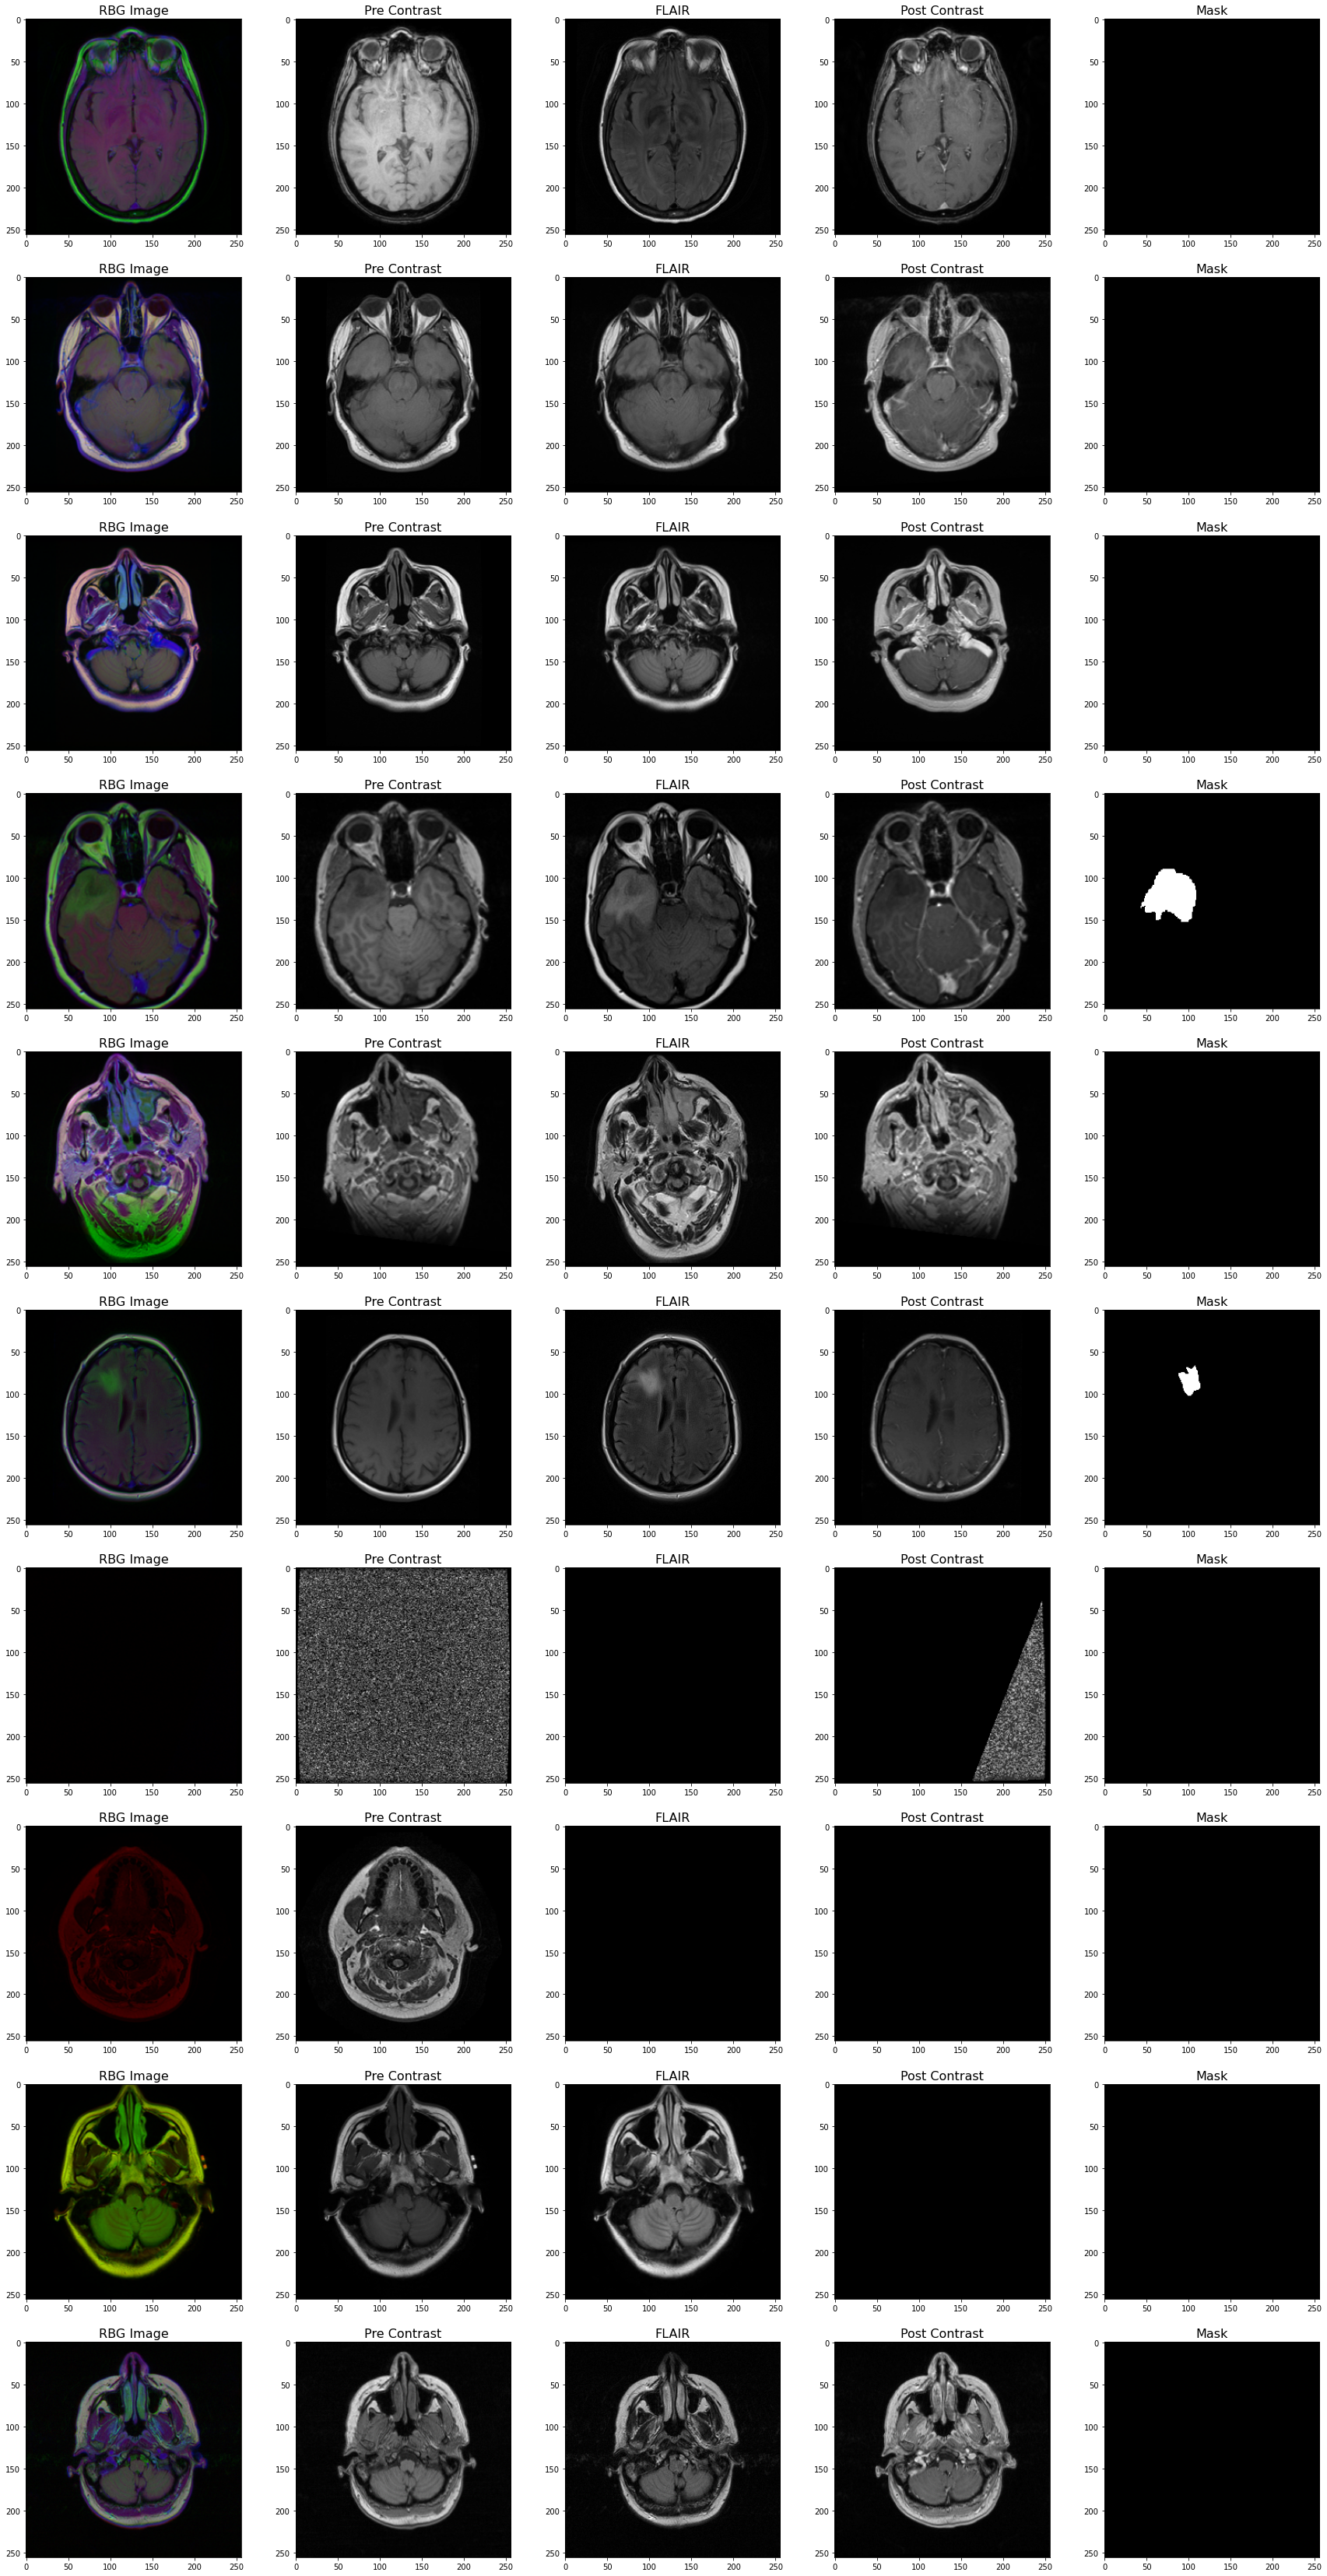

In [9]:
plt.figure(figsize=(30,60))

for j in range(0, 10):
    index = random.randrange(0, 1000, 3)
    
    mri = np.asarray(load_img(
         join(DIR, train_df['mris'][index]), 
         target_size=(SIZE, SIZE)))
    mask = np.asarray(load_img(
        join(DIR, train_df['masks'][index]), 
        target_size=(SIZE, SIZE), 
        color_mode="grayscale"))
             
    images = [mri, mri[:,:,0], mri[:,:,1], mri[:,:,2], mask]
    titles = ["RBG Image", "Pre Contrast", "FLAIR", "Post Contrast", "Mask"]
    
    for i in range(0, 5):
        ax = plt.subplot(10, 5, (j*5)+i+1)
        ax.set_title(titles[i], fontsize = 16)
        plt.imshow(X=images[i], cmap='gray')

plt.show()

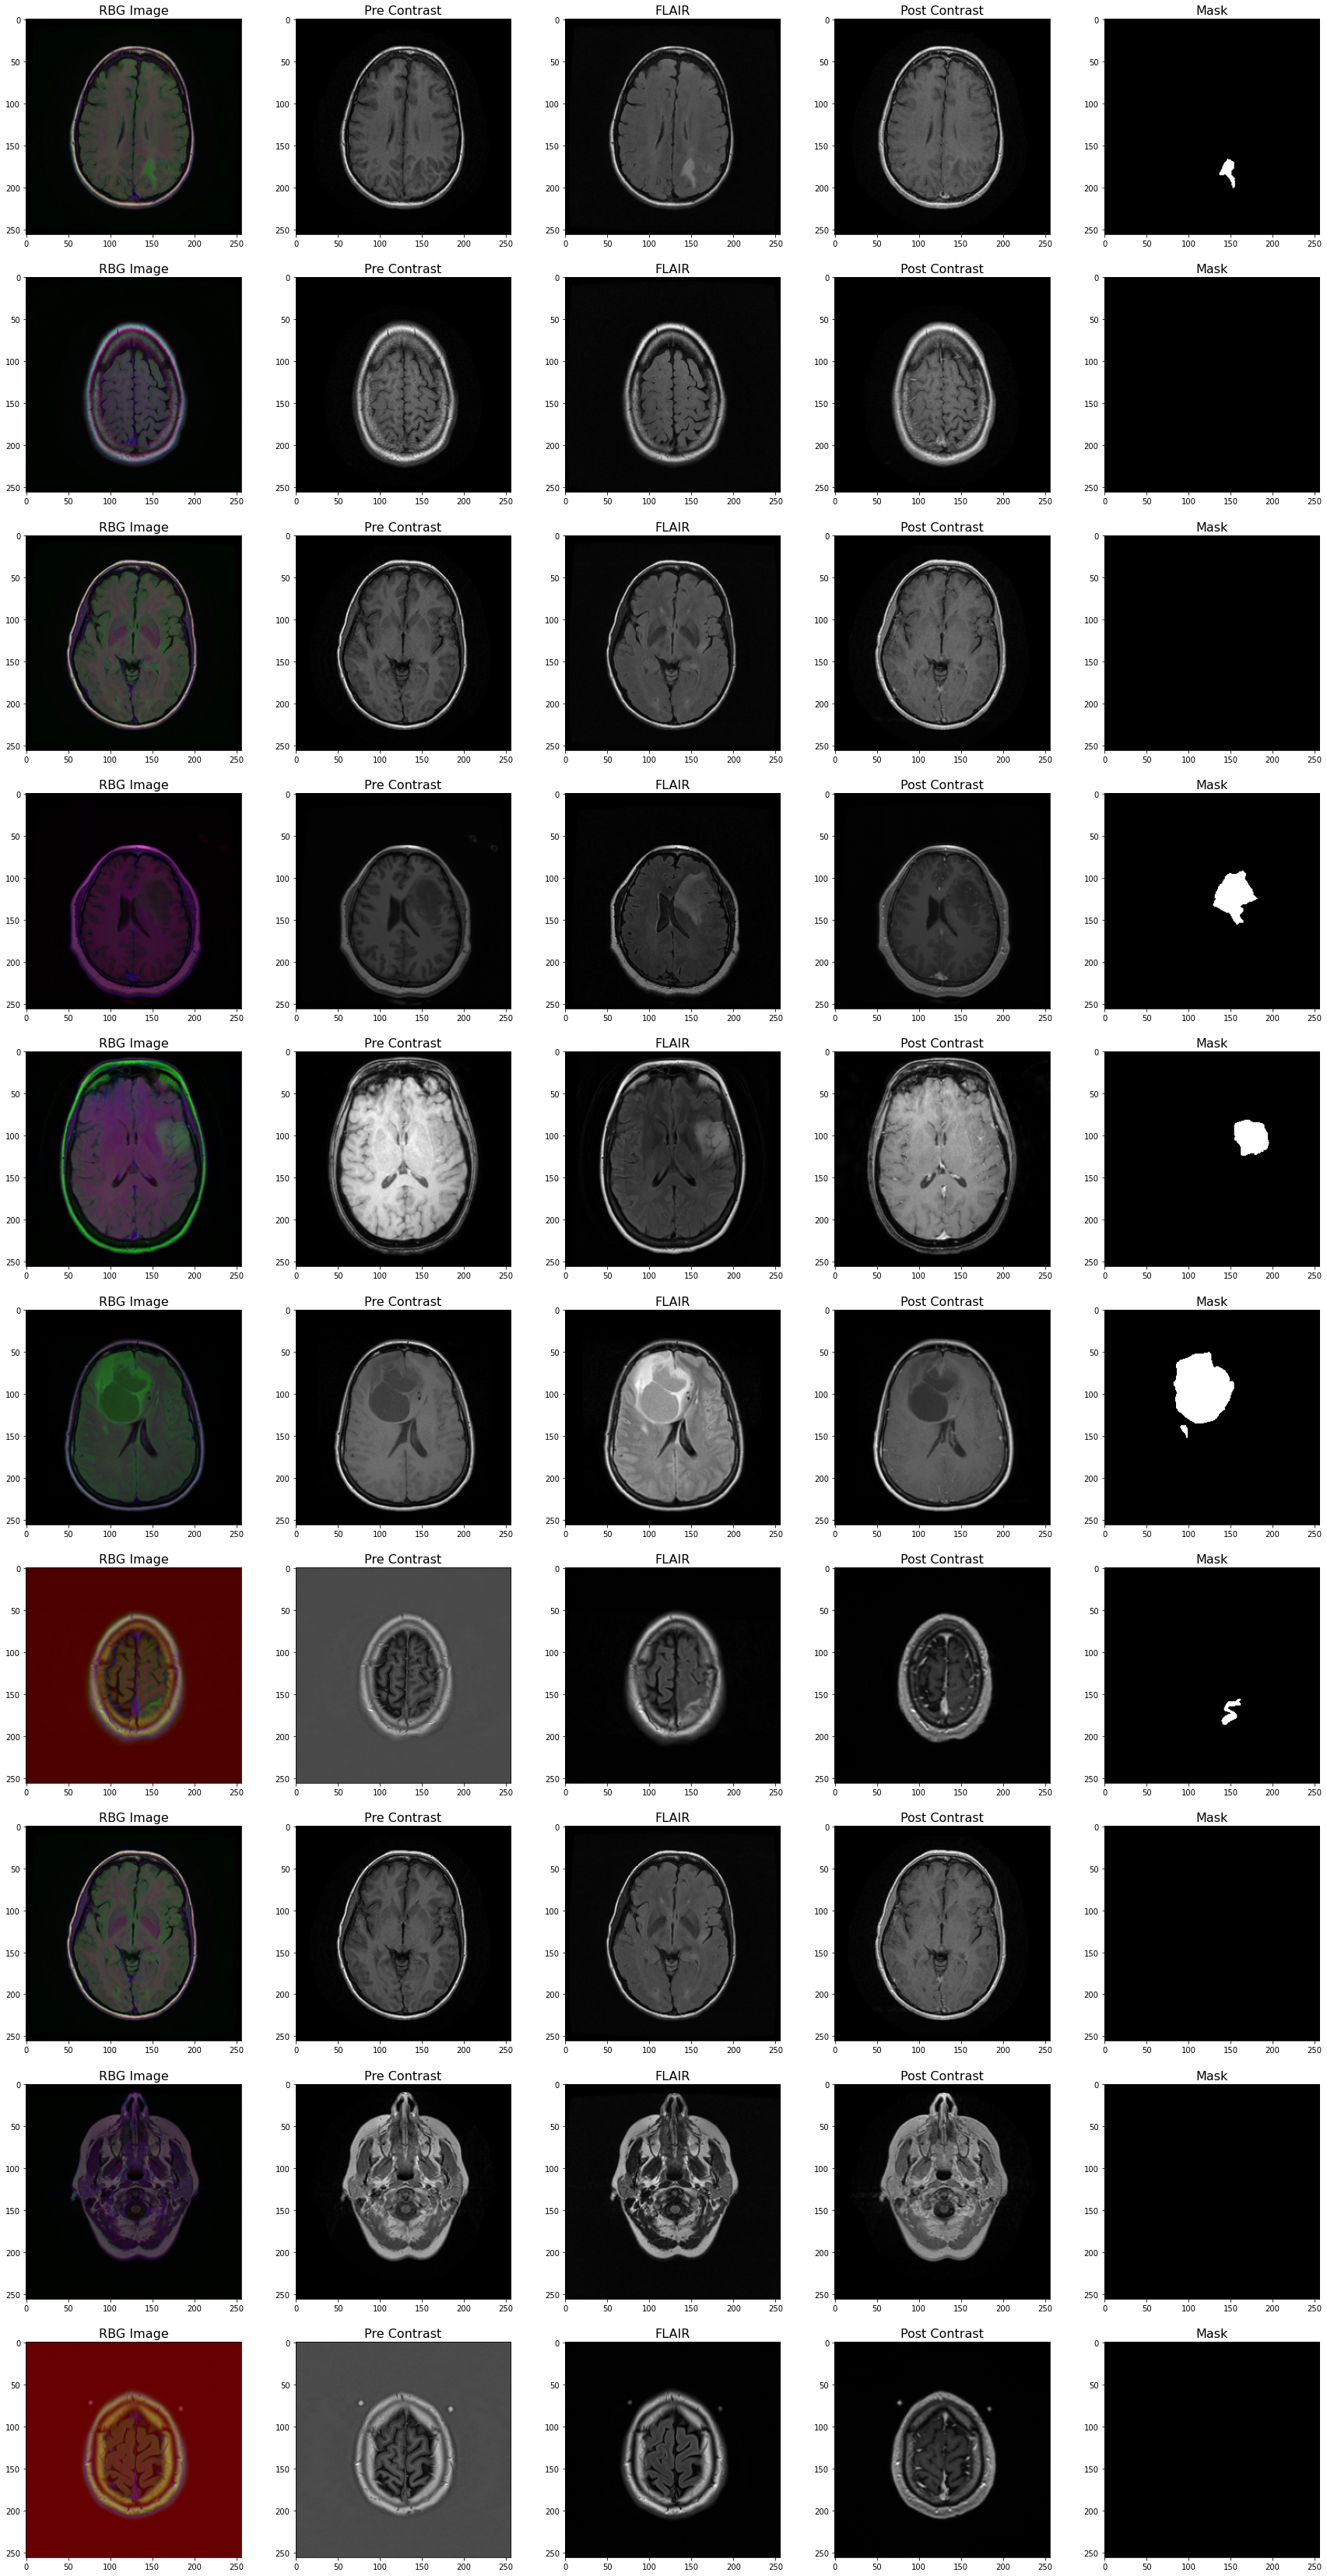

In [10]:
plt.figure(figsize=(30,60))

for j in range(0, 10):
    index = random.randrange(0, 200, 3)
    
    mri = np.asarray(load_img(
         join(DIR, val_df['mris'][index]), 
         target_size=(SIZE, SIZE)))
    mask = np.asarray(load_img(
        join(DIR, val_df['masks'][index]), 
        target_size=(SIZE, SIZE), 
        color_mode="grayscale"))
             
    images = [mri, mri[:,:,0], mri[:,:,1], mri[:,:,2], mask]
    titles = ["RBG Image", "Pre Contrast", "FLAIR", "Post Contrast", "Mask"]
    
    for i in range(0, 5):
        ax = plt.subplot(10, 5, (j*5)+i+1)
        ax.set_title(titles[i], fontsize = 16)
        plt.imshow(X=images[i], cmap='gray')

plt.show()

# Data Generator

In [11]:
#Verileri kendi ön işlememizi yapacağımız için bir Data Generator class yazmamız gerekmektedir.
def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

class BrainMRIs(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, directory):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.directory = directory

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size, self.img_size, self.img_size, 3), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(join(self.directory, path), target_size=(self.img_size, self.img_size))
            x[j] = img
            
        y = np.zeros((self.batch_size, self.img_size, self.img_size, 1), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(join(self.directory, path), target_size=(self.img_size, self.img_size), color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        
        return adjust_data(x, y)

In [12]:
train_gen = BrainMRIs(BATCH_SIZE, SIZE, train_images, train_targets, DIR)
val_gen = BrainMRIs(BATCH_SIZE, SIZE, val_images, val_targets, DIR)
test_gen = BrainMRIs(BATCH_SIZE, SIZE, test_images, test_targets, DIR)

# Loss function and Metrics

In [13]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef = keras.backend.flatten(y_true)
    y_predf = keras.backend.flatten(y_pred)
    And = keras.backend.sum(y_truef*y_predf)
    return((2* And + smooth) / (keras.backend.sum(y_truef) + keras.backend.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = keras.backend.sum(y_true * y_pred)
    sum_ = keras.backend.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef = keras.backend.flatten(y_true)
    y_predf = keras.backend.flatten(y_pred)

    return - iou(y_true, y_pred)

# UNet

# Model

In [14]:
keras.backend.clear_session()
#Unet modelleri kodlayıcı-kod çözücü yapısına sahiptir. 
#Giriş olarak verilen beyin görüntüleri çıkışta segmente edilmiş olarak karşımıza çıkar. 

In [15]:
inputs = layers.Input((SIZE, SIZE, INPUT_CHANNELS))

c1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
c1 = layers.Dropout(0.2)(c1)
c1 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', name="conv1_2")(c1)
c1 = layers.BatchNormalization(axis=3)(c1)
c1 = layers.Activation('relu')(c1)
input_1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv2_1')(input_1)
c2 = layers.Dropout(0.2)(c2)
c2 = layers.Conv2D(64, kernel_size=(3, 3), padding='same', name="conv2_2")(c2)
c2 = layers.BatchNormalization(axis=3)(c2)
c2 = layers.Activation('relu')(c2)
input_2 = layers.MaxPooling2D((2, 2))(c2)

c3 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='conv3_1')(input_2)
c3 = layers.Dropout(0.2)(c3)
c3 = layers.Conv2D(128, kernel_size=(3, 3), padding='same', name="conv3_2")(c3)
c3 = layers.BatchNormalization(axis=3)(c3)
c3 = layers.Activation('relu')(c3)
input_3 = layers.MaxPooling2D((2, 2))(c3)

c4 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='conv4_1')(input_3)
c4 = layers.Dropout(0.2)(c4)
c4 = layers.Conv2D(256, kernel_size=(3, 3), padding='same', name="conv4_2")(c4)
c4 = layers.BatchNormalization(axis=3)(c4)
c4 = layers.Activation('relu')(c4)
input_4 = layers.MaxPooling2D((2, 2))(c4)

c5 = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='conv5_1')(input_4)
c5 = layers.Dropout(0.2)(c5)
c5 = layers.Conv2D(512, kernel_size=(3, 3), padding='same', name="conv5_2")(c5)
c5 = layers.BatchNormalization(axis=3)(c5)
c5 = layers.Activation('relu')(c5)

u6 = layers.Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv6_1')(c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='conv6_2')(u6)
c6 = layers.Dropout(0.2)(c6)
c6 = layers.Conv2D(256, kernel_size=(3, 3), padding='same', name="conv6_3")(c6)
c6 = layers.BatchNormalization(axis=3)(c6)
c6 = layers.Activation('relu')(c6)

u7 = layers.Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv7_1')(c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='conv7_2')(u7)
c7 = layers.Dropout(0.2)(c7)
c7 = layers.Conv2D(128, kernel_size=(3, 3), padding='same', name="conv7_3")(c7)
c7 = layers.BatchNormalization(axis=3)(c7)
c7 = layers.Activation('relu')(c7)

u8 = layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv8_1')(c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv8_2')(u8)
c8 = layers.Dropout(0.2)(c8)
c8 = layers.Conv2D(64, kernel_size=(3, 3), padding='same', name="conv8_3")(c8)
c8 = layers.BatchNormalization(axis=3)(c8)
c8 = layers.Activation('relu')(c8)

u9 = layers.Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv9_1')(c8)
u9 = layers.concatenate([u9, c1])
c9 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='conv9_2')(u9)
c9 = layers.Dropout(0.2)(c9)
c9 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', name="conv9_3")(c9)
c9 = layers.BatchNormalization(axis=3)(c9)
c9 = layers.Activation('relu')(c9)

outputs = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid', padding='same', name="output")(c9)

model = keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv1_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 256, 256, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

# Training

In [16]:
EPOCHS = 30
learning_rate = 1e-2
decay_rate = learning_rate / 10
#model eğitimi yapılmaktadır.

In [21]:
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=learning_rate, 
        beta_1=0.9, 
        beta_2=0.999, 
        epsilon=None, 
        decay=decay_rate, 
        amsgrad=False), 
    loss=dice_coef_loss,
    metrics=["binary_accuracy", iou, dice_coef])

model_checkpoint = keras.callbacks.ModelCheckpoint('erkin.hdf5', verbose=1, save_best_only=True)

history = model.fit(
    train_gen, 
    validation_data=val_gen,
    epochs=10,   #10dan yüksek bir değer olsa model daha iyi öğrenilebilir fakat bilgisayarım cpuda çalıştırdığı için arttıramadım.
    callbacks=[model_checkpoint])

Epoch 1/10
94/94 [==============================] - 3399s 36s/step - loss: -0.4305 - binary_accuracy: 0.9875 - iou: 0.2857 - dice_coef: 0.4305 - val_loss: -0.3499 - val_binary_accuracy: 0.9745 - val_iou: 0.2206 - val_dice_coef: 0.3499

Epoch 00001: val_loss improved from inf to -0.34985, saving model to erkin.hdf5
Epoch 2/10
94/94 [==============================] - 3371s 36s/step - loss: -0.5761 - binary_accuracy: 0.9917 - iou: 0.4173 - dice_coef: 0.5761 - val_loss: -0.3360 - val_binary_accuracy: 0.9709 - val_iou: 0.2082 - val_dice_coef: 0.3360

Epoch 00002: val_loss did not improve from -0.34985
Epoch 3/10
94/94 [==============================] - 3251s 35s/step - loss: -0.6448 - binary_accuracy: 0.9934 - iou: 0.4858 - dice_coef: 0.6448 - val_loss: -0.5599 - val_binary_accuracy: 0.9905 - val_iou: 0.4021 - val_dice_coef: 0.5599

Epoch 00003: val_loss improved from -0.34985 to -0.55993, saving model to erkin.hdf5
Epoch 4/10
94/94 [==============================] - 3216s 34s/step - loss: 

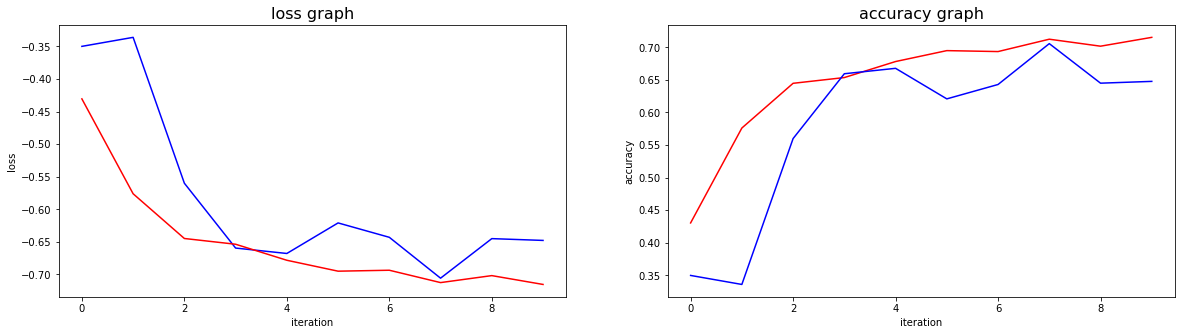

In [27]:
a = history.history

list_trainloss = a['loss']
list_testloss = a['val_loss']
list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

plt.figure(figsize=(20,5))

ax = plt.subplot(1, 2, 1)
ax.set_title('loss graph', fontsize = 16)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')

ax = plt.subplot(1, 2, 2)
ax.set_title('accuracy graph', fontsize = 16)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')

plt.show()
#model eğitimi sonucu dğruluk ve loss grafikleri
#mavi validation kırmızı train çizgileri

# Testing

In [28]:
# Unet modelinin test edildiği kısım. Beklenen maskelenmiş görüntülerle segmentasyon sonucu çıkan görüntüler karşılaştırılır. 
x = np.zeros((15, SIZE, SIZE, 3), dtype="float32")   
disp_x = np.zeros((15, SIZE, SIZE, 3), dtype="uint8")
y = np.zeros((15, SIZE, SIZE, 1), dtype="uint8")

for j in range(0, 15):
    x[j] = np.asarray(load_img(
         join(DIR, test_df['mris'][j]), 
         target_size=(SIZE, SIZE)))
    disp_x[j] = x[j]
    img = np.asarray(load_img(
        join(DIR, test_df['masks'][j]), 
        target_size=(SIZE, SIZE), 
        color_mode="grayscale"))
    y[j] = np.expand_dims(img, 2)

In [29]:
model = keras.models.load_model('erkin.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
preds = model.predict(x / 255)

In [30]:
preds_t = (preds > 0.5).astype(np.uint8)
print(np.amax(preds))
print(np.amax(preds_t))
print(preds.shape)
print(np.unique(preds_t, return_counts=True))

1.0
1
(15, 256, 256, 1)
(array([0, 1], dtype=uint8), array([966895,  16145], dtype=int64))


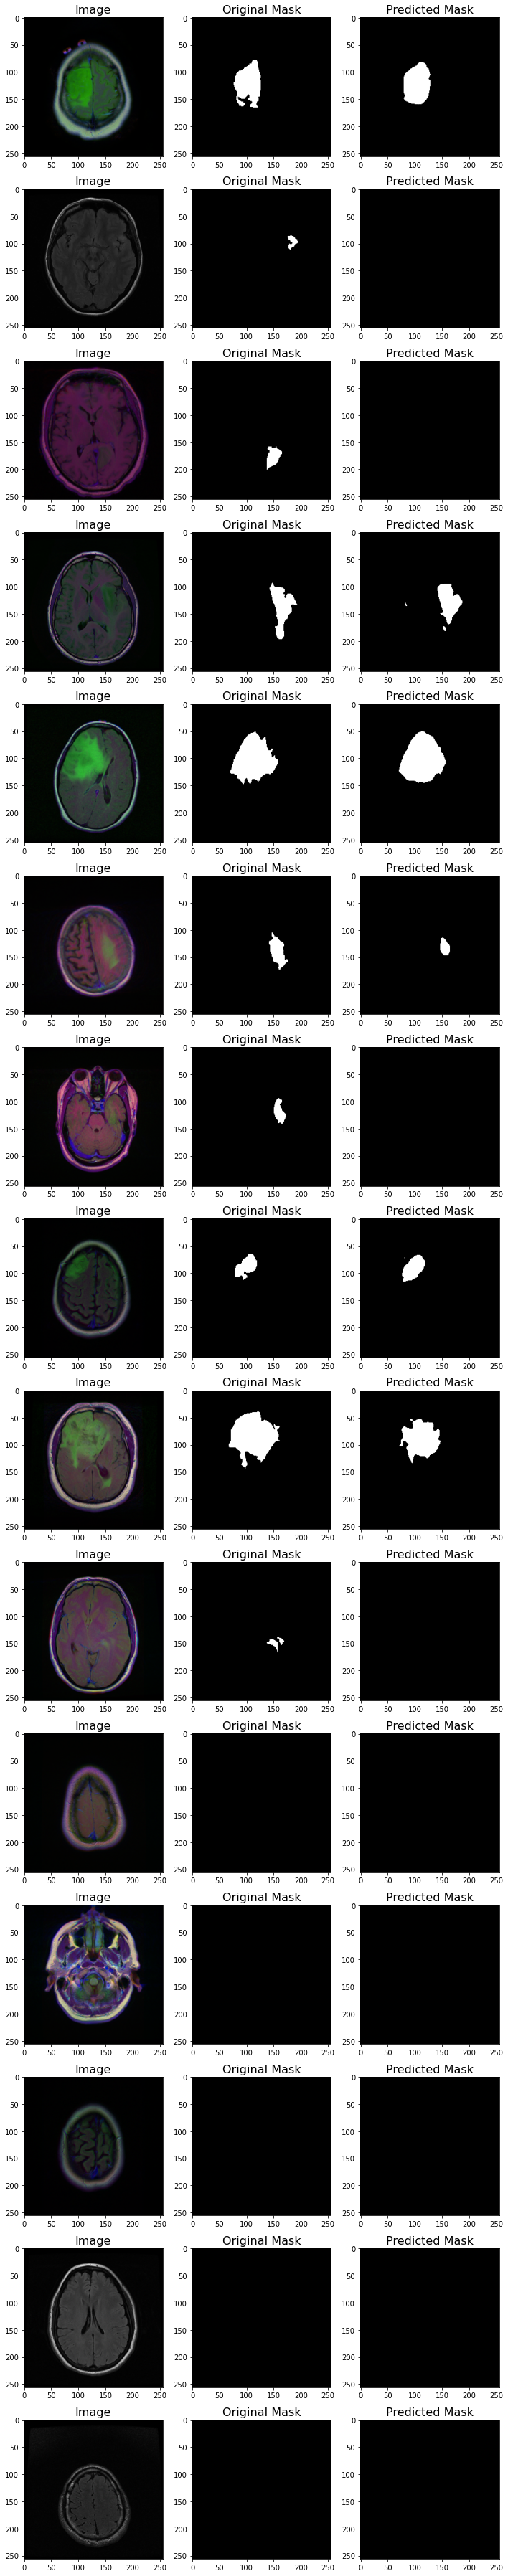

In [31]:
plt.figure(figsize=(10,50))

titles = ["Image", "Original Mask", "Predicted Mask"]

for j in range(15):
    images = [disp_x[j], y[j], preds_t[j]**255]
    for i in range(0, 3):
        ax = plt.subplot(15, 3, (j*3)+i+1)
        ax.set_title(titles[i], fontsize = 16)
        plt.imshow(X=images[i], cmap='gray')
        
plt.tight_layout()
plt.show()
#Modelin karşılaştırılması için görüntülerin birbiri ile kıyaslandığı bölüm sonuç kısmı

# RESUNET 

In [2]:
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [3]:
data = pd.read_csv('lgg-mri-segmentation/kaggle_3m/data.csv')

In [4]:
data_map = []
for sub_dir_path in glob.glob("C:\\Users\\90505\\lgg-mri-segmentation\\kaggle_3m\\*"):
    try:
        dir_name = sub_dir_path.split('\\')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = os.path.join(sub_dir_path, filename)
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)
print(data_map)

[WinError 267] Dizin adı geçersiz: 'C:\\Users\\90505\\lgg-mri-segmentation\\kaggle_3m\\data.csv'
[WinError 267] Dizin adı geçersiz: 'C:\\Users\\90505\\lgg-mri-segmentation\\kaggle_3m\\README.md'
['TCGA_CS_4941_19960909', 'C:\\Users\\90505\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_1.tif', 'TCGA_CS_4941_19960909', 'C:\\Users\\90505\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', 'TCGA_CS_4941_19960909', 'C:\\Users\\90505\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10_mask.tif', 'TCGA_CS_4941_19960909', 'C:\\Users\\90505\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', 'TCGA_CS_4941_19960909', 'C:\\Users\\90505\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11_mask.tif', 'TCGA_CS_4941_19960909', 'C:\\Users\\90505\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', 'TCGA_CS_

In [5]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})

In [6]:
df_imgs = df[~df['path'].astype(str).str.contains("mask")]
df_masks = df[df['path'].astype(str).str.contains("mask")]

# Dosya yolu satır uzunluğu görüntüleri
BASE_LEN = 32 
END_IMG_LEN = 4 
END_MASK_LEN = 9 # Maskelenmiş görüntü ile beyin MR görüntüsünün birbiriyle eşitlenmesi için kullanıldı.

# Veri sıralama
imgs = sorted(df_imgs["path"].values, key=lambda x : os.path.basename(x))
masks = sorted(df_masks["path"].values, key=lambda x : os.path.basename(x)[:-END_MASK_LEN])


# Sıralama Kontrolü
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: C:\Users\90505\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61A_20000127\TCGA_HT_A61A_20000127_1.tif 
Path to the Mask: C:\Users\90505\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61A_20000127\TCGA_HT_A61A_20000127_1_mask.tif


In [7]:
# Sıralanmış verinin son hali
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

patient_id  \
0     TCGA_CS_4941_19960909   
1     TCGA_CS_4941_19960909   
2     TCGA_CS_4941_19960909   
3     TCGA_CS_4941_19960909   
4     TCGA_CS_4941_19960909   
...                     ...   
3924  TCGA_HT_A61B_19991127   
3925  TCGA_HT_A61B_19991127   
3926  TCGA_HT_A61B_19991127   
3927  TCGA_HT_A61B_19991127   
3928  TCGA_HT_A61B_19991127   

                                             image_path  \
0     C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...   
1     C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...   
2     C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...   
3     C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...   
4     C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...   
...                                                 ...   
3924  C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...   
3925  C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...   
3926  C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...   
3927  C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...   
3928  C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...   

                                              mask_path  mask  
0     C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...     0  
1     C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...     0  
2     C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...     1  
3     C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...     1  
4     C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...     1  
...                                                 ...   ...  
3924  C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...     0  
3925  C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...     0  
3926  C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...     0  
3927  C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...     0  
3928  C:\Users\90505\lgg-mri-segmentation\kaggle_3m\...     0  

[3929 rows x 4 columns]

# CRETING TEST, TRAIN & VAL SET

In [8]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Veri çerçevesinden akışta kategorik modu kullanmak için maske sütunundaki verileri dize biçimine dönüştürüldü.
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15)

In [10]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


#  ResUNet Model

In [11]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [12]:
# test, eğitim ve val setleri oluşturma
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [13]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    # batch_size uzunluğunun indeksini oluştur
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    # batch size'a göre yukarıda oluşturulan dizinlere karşılık gelen ImageId'yi alındı.
    list_ids = [self.ids[i] for i in indexes]

    # batch size'a göre yukarıda oluşturulan dizinlere karşılık gelen MaskId'yi alındı.
    list_mask = [self.mask[i] for i in indexes]


    # X(properties) ve y(label) için veri oluşturuldu.
    X, y = self.__data_generation(list_ids, list_mask)

    return X, y

  def on_epoch_end(self):
    
    # giriş veri çerçevesine dayalı dizin dizisini alma.
    self.indexes = np.arange(len(self.ids))

    # karıştırma
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):

    # boş dizi oluşturduk (batch_size,height,width,depth) 
    # Maske sadece 1 kanaldan oluştuğu için giriş için derinlik 3, çıkış için derinlik 1 olarak alınmıştır.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    # iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      img_path = str(list_ids[i])
      
      mask_path = str(list_mask[i])
      
      # orijinal görüntüyü ve ilgili maske görüntüsünü okuma
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      # yeniden boyutlandırma ve bunları float64 türünde bir diziye dönüştürme
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)
 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      X[i,] = img
      
      # görüntünün boyutunu (256,256)'dan (256,256,1)'e genişletme
      y[i,] = np.expand_dims(mask, axis = 2)
    
    # y normalleştirme
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

In [14]:
# model yaratma kısmı.
def resblock(X, f):
    X_copy = X 
    
    # main part
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # kısa part
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # main part ve kısa part birleştirme
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [15]:
input_shape = (256,256,3)
X_input = Input(input_shape) #giriş şeklinin tensörünü başlatma !!!!!!!!!!!! buna bir bak

# Aşama 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# Aşama 2
conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)

# Aşama 3
conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)

# Aşama 4
conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)

# Aşama 5 
conv_5 = resblock(pool_4, 256)

# Örnek Aşama 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

# Örnek Aşama 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

# Örnek Aşama 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

# Örnek Aşama 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

# final 
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
______________________________________________________________________________________________

# TRAINING SEGMENTATION MODEL

In [16]:
# ResUNet modeli için özel bir kayıp işlevi tanımlandı.

from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [17]:
#Model tanımlama
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
seg_model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# daha düşük doğrulama kaybıyla en iyi modeli kaydedildi.
checkpointer = ModelCheckpoint(filepath="resuneterkin.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

C:\Users\90505\AppData\Local\Programs\Python\Python36\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
#Model eğitimi, epoch değerini Unet mimarisi ile aynı olsun diye 10 seçildi.
h = seg_model.fit(train_data, 
                  epochs = 10, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/10
72/72 [==============================] - 393s 5s/step - loss: 0.8414 - tversky: 0.2049 - val_loss: 0.7787 - val_tversky: 0.2834

Epoch 00001: val_loss improved from inf to 0.77867, saving model to resuneterkin.hdf5


C:\Users\90505\AppData\Local\Programs\Python\Python36\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
72/72 [==============================] - 386s 5s/step - loss: 0.5138 - tversky: 0.5848 - val_loss: 0.7921 - val_tversky: 0.2667

Epoch 00002: val_loss did not improve from 0.77867
Epoch 3/10
72/72 [==============================] - 386s 5s/step - loss: 0.3811 - tversky: 0.7209 - val_loss: 0.5712 - val_tversky: 0.5256

Epoch 00003: val_loss improved from 0.77867 to 0.57118, saving model to resuneterkin.hdf5
Epoch 4/10
72/72 [==============================] - 387s 5s/step - loss: 0.3530 - tversky: 0.7486 - val_loss: 0.4066 - val_tversky: 0.6970

Epoch 00004: val_loss improved from 0.57118 to 0.40661, saving model to resuneterkin.hdf5
Epoch 5/10
72/72 [==============================] - 387s 5s/step - loss: 0.2943 - tversky: 0.8029 - val_loss: 0.4004 - val_tversky: 0.7028

Epoch 00005: val_loss improved from 0.40661 to 0.40044, saving model to resuneterkin.hdf5
Epoch 6/10
72/72 [==============================] - 387s 5s/step - loss: 0.2668 - tversky: 0.8265 - val_loss: 0.3435 - 

In [19]:
# modeli daha sonra kullanabilmek için json dosyasına kaydettik.
seg_model_json = seg_model.to_json()
with open("resuneterkin.json", "w") as json_file:
    json_file.write(seg_model_json)

In [20]:
h.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

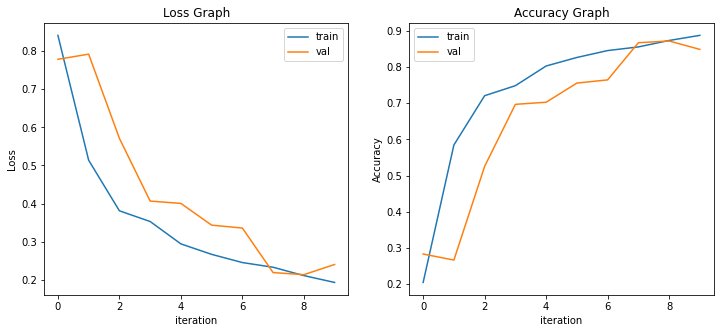

In [21]:
#ResUnet mimarisi için accuracy ve loss değerleri karşılaştırma için bunları kullanacağız.
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Loss Graph");
plt.ylabel("Loss");
plt.xlabel("iteration");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['tversky']);
plt.plot(h.history['val_tversky']);
plt.title("Accuracy Graph");
plt.ylabel("Accuracy");
plt.xlabel("iteration");
plt.legend(['train', 'val']);

# Testing

In [22]:
#ResUnet modelini test etme kısmı. Beklenen maskelenmiş görüntülerle segmentasyon sonucu çıkan görüntüler karşılaştırılır. 
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation accuracy is {:.2f}%".format(tv*100))


6/6 [==============================] - 6s 1s/step - loss: 0.2356 - tversky: 0.8535
Segmentation accuracy is 85.35%


# Sonuç
İki mimari kodlanıp eğitimi yapılmıştır.  
elde edilen sonuçlar şöyledir;  
Unet: doğruluk değeri = %70.5  
ResUnet: doğruluk değeri = %85.35  
Kullanılan veri seti için ResUnet çok daha iyi sonuç vermiş ve tümör yakalama ihtimali ve yakalanılan tümörün doğruluk oranı çok daha fazladır.  